In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import scipy.spatial.distance as dis
from numpy import random as rd
import imageio
import glob
import os
from PIL import Image

Photo size: (231,195) to (80,68)

In [2]:
face_exp=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']

# Resize images

In [3]:
train_list=glob.glob(os.path.join('Training','*.pgm'))
test_list=glob.glob(os.path.join('Testing','*.pgm'))
for i in range(len(train_list)):
    img=Image.open(train_list[i])
    img.thumbnail((80,80))
    img.save(train_list[i])
for i in range(len(test_list)):
    img=Image.open(test_list[i])
    img.thumbnail((80,80))
    img.save(test_list[i])

#PCA

In [4]:
train_list=glob.glob(os.path.join('Training','*.pgm'))
train_list.sort()
train_data=[]
for i in range(len(train_list)):
    train_data.append(cv2.imread(train_list[i],0).reshape(-1))
test_list=glob.glob(os.path.join('Testing','*.pgm'))
test_list.sort()
test_data=[]
for i in range(len(test_list)):
    test_data.append(cv2.imread(test_list[i],0).reshape(-1))

In [5]:
label=[]
for i in range(135):
    for j in range(15):
        if face_exp[j] in train_list[i]:
            label.append(j)
            break
label2=[]
for i in range(30):
    for j in range(15):
        if face_exp[j] in test_list[i]:
            label2.append(j)
            break

In [ ]:
h=80
w=68
n=len(train_data)
X=np.zeros((n,h*w))
for i in range(n):
    X[i]=train_data[i]
X=X.T
m=len(test_data)
Y=np.zeros((m,h*w))
for i in range(m):
    Y[i]=test_data[i]
Y=Y.T

In [ ]:
X_m=np.mean(X,axis=1).reshape(-1,1)
X_c=np.subtract(X,X_m)
Cov=1/135*X_c@X_c.T
eigenvalue,eigenvector=np.linalg.eigh(Cov)
eigenvector/=np.linalg.norm(eigenvector,axis=0)
sort_index=np.argsort(-eigenvalue)
W=eigenvector[:,sort_index[:133]]

In [ ]:
Z=W.T@X_c
YY=W@Z+X_m

In [16]:
def accurancy(Z1,Z2):
    '''
    Z1: Training data in new space
    Z2: Testing data in new space
    Using k-NN to determine the label of Testing data
    '''
    guess=[]
    for i in range(30):
        dist=Z1-Z2[:,i].reshape(-1,1)
        dist=np.sum(np.power(dist,2),axis=0)
        index=np.argsort(dist)
        list1=[]
        for j in range(3):
            list1.append(label[index[j]])
        labelcount=np.zeros(15)
        for j in range(15):
            labelcount[j]=list1.count(j)
        if np.max(labelcount)>1:
            guess.append(np.argmax(labelcount))
        else:
            guess.append(list1[0])
    T=0
    for i in range(30):
        if label2[i]==guess[i]:
            T+=1
    print(T/30)

In [ ]:
Z1=W.T@(X-X_m)
Z2=W.T@(Y-X_m)

In [ ]:
accurancy(Z1,Z2)

0.8666666666666667


#Supervised

In [11]:
h=80
w=68

In [7]:
list_face_exp=[]
for i in range(15):
    list1=glob.glob(os.path.join('Training','*'+face_exp[i]+'*.pgm'))
    list_face_exp.append(list1)

In [8]:
train_data=[]
label_num=[]
for i in range(15):
    label_num.append(len(list_face_exp[i]))
    for j in range(len(list_face_exp[i])):
        train_data.append(cv2.imread(list_face_exp[i][j],0).reshape(-1))

In [9]:
# 30 clusters from 15 subjects
new_label_num=4*np.ones(30)
for i in range(0,30,2):
    new_label_num[i]+=1

In [12]:
list_X=[]
list_face_m=[]
for i in range(30):
    X_temp=np.zeros((int(new_label_num[i]),h*w))
    m=int(np.sum(new_label_num[:i]))
    for j in range(m,m+int(new_label_num[i])):
        X_temp[j-m]=train_data[j]
    list_X.append(X_temp)
for i in range(30):
    A=np.mean(list_X[i],axis=0)
    list_face_m.append(A)

# Modified LDA

In [ ]:
Sw=np.zeros((h*w,h*w))
for i in range(30):
    X_c=np.subtract(list_X[i],list_face_m[i])
    Sw+=X_c.T@X_c

In [ ]:
m=1/135*np.sum(train_data,axis=0)

In [ ]:
Sb=np.zeros((h*w,h*w))
for i in range(30):
    X_c=np.subtract(list_face_m[i],m).reshape(-1,1)
    Sb+=new_label_num[i]*X_c@X_c.T

In [ ]:
eigenvalue,eigenvector=np.linalg.eigh(Sb) # rank 29

In [ ]:
sort_index=np.argsort(-eigenvalue)
eigenvalue[sort_index[:29]]

array([3.51219143e+08, 2.96943527e+08, 1.62943423e+08, 1.40078585e+08,
       9.49455620e+07, 8.15931098e+07, 6.94507976e+07, 5.38267599e+07,
       4.26718690e+07, 3.53333756e+07, 3.02543522e+07, 2.59441096e+07,
       2.14695895e+07, 1.91066943e+07, 1.47702270e+07, 9.91047268e+06,
       8.58176626e+06, 6.62555668e+06, 5.34680051e+06, 4.68783768e+06,
       3.86782257e+06, 3.41417852e+06, 3.19914947e+06, 3.04323806e+06,
       2.88754918e+06, 2.69747158e+06, 2.22598744e+06, 1.89942818e+06,
       1.73976196e+06])

In [ ]:
Y=eigenvector[:,sort_index[:29]]
Db=np.diag(eigenvalue[sort_index[:29]])
Db_inverse_square_root=np.diag(1/np.diag(np.sqrt(Db)))
Z=Y@Db_inverse_square_root

In [ ]:
eigenvalue,eigenvector=np.linalg.eigh(Z.T@Sw@Z)
sort_index=np.argsort(-eigenvalue)
U=eigenvector[:,sort_index]
A=U.T@Z.T

In [ ]:
Dw=np.diag(np.diag(A@Sw@A.T))

In [ ]:
Z1=np.diag(1/np.diag(np.sqrt(Dw)))@A@X
Z2=np.diag(1/np.diag(np.sqrt(Dw)))@A@Y

In [ ]:
accurancy(Z1,Z2)

1.0


# eigenface

In [ ]:
rd_list=[]
for i in range(10):
    while 1:
        ind=rd.randint(0,n)
        if rd_list.count(ind)==0:
            rd_list.append(ind)
            break

In [ ]:
rd_list

[30, 106, 105, 20, 97, 44, 94, 107, 43, 19]

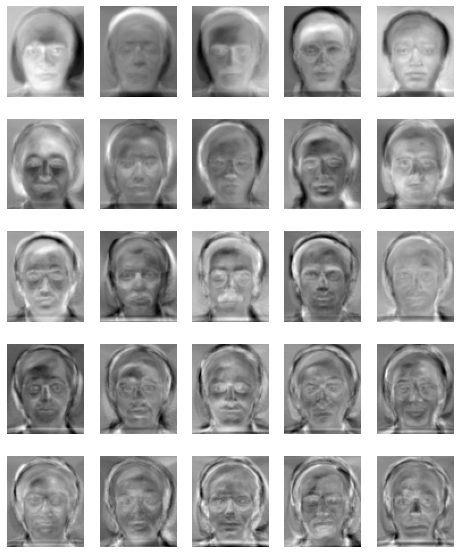

In [ ]:
plt.figure(figsize=(8,10))
for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.imshow(W[:,i].reshape(h,w),cmap='gray')

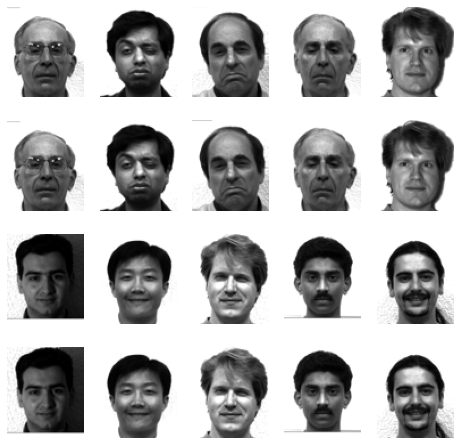

In [ ]:
plt.figure(figsize=(8,8))
for i in range(5):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data[rd_list[i]].reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+6)
    plt.axis('off')
    plt.imshow(YY[:,rd_list[i]].reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+11)
    plt.axis('off')
    plt.imshow(train_data[rd_list[i+5]].reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+16)
    plt.axis('off')
    plt.imshow(YY[:,rd_list[i+5]].reshape(h,w),cmap='gray')

# fisherface

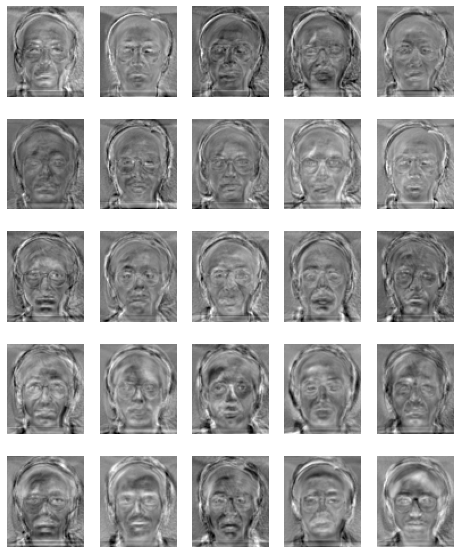

In [ ]:
plt.figure(figsize=(8,10))
for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.imshow(A[i,:].reshape(h,w),cmap='gray')

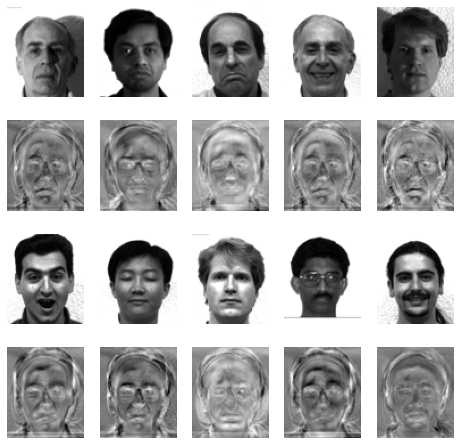

In [ ]:
plt.figure(figsize=(8,8))
for i in range(5):
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(train_data[rd_list[i]].reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+6)
    plt.axis('off')
    P=A.T@np.linalg.inv(Dw)@A@train_data[rd_list[i]].reshape(-1,1)
    plt.imshow(P.reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+11)
    plt.axis('off')
    plt.imshow(train_data[rd_list[i+5]].reshape(h,w),cmap='gray')
for i in range(5):
    plt.subplot(4,5,i+16)
    plt.axis('off')
    P=A.T@np.linalg.inv(Dw)@A@train_data[rd_list[i+5]].reshape(-1,1)
    plt.imshow(P.reshape(h,w),cmap='gray')

# Kernel PCA

In [6]:
def kernel(X1,X2,gamma,d,mode):
    '''
    Impletation of kernel
    X1: (n,h*w)-array
    X2: (m,h*w)-array
    gamma: parameters
    return a (n,m)-array
    ''' 
    if mode==0:
        return X1@X2.T
    elif mode==1:
        return np.power(gamma*X1@X2.T,d)
    else:
        XY=np.zeros((np.size(X1,0)+np.size(X2,0),h*w))
        XY[:np.size(X1,0),:]=X1
        XY[np.size(X1,0):,:]=X2
        K=dis.squareform(np.exp(-gamma*dis.pdist(XY,'sqeuclidean')))
        return K[:np.size(X1,0),np.size(X1,0):]

In [13]:
h=80
w=68
n=len(train_data)
X=np.zeros((n,h*w))
for i in range(n):
    X[i]=train_data[i]
m=len(test_data)
Y=np.zeros((m,h*w))
for i in range(m):
    Y[i]=test_data[i]

In [19]:
id_M=1/135*np.identity(135)
id_M_new=1/135*np.ones((135,30))

In [20]:
for gamma in [1e-5,1e-6,1e-7,1e-2,1e-3,1e-4]:
    for d in range(2,7):
        print(gamma,d)
        K=kernel(X,X,gamma,d,1)
        K_c=K-id_M@K-K@id_M+id_M@K@id_M
        eigenvalue,eigenvector=np.linalg.eigh(K_c)
        eigenvector/=np.linalg.norm(eigenvector,axis=0)
        sort_index=np.argsort(-eigenvalue)
        W=eigenvector[:,sort_index[:134]]
        K_new=kernel(X,Y,gamma,d,1)
        K_new_c=K_new-K@id_M_new-id_M@K_new+id_M@K@id_M_new
        Z1=W.T@K
        Z2=W.T@K_new
        accurancy(Z1,Z2)
        Z1=W.T@K_c
        Z2=W.T@K_new_c
        accurancy(Z1,Z2)

1e-05 2
0.7666666666666667
0.06666666666666667
1e-05 3
0.7666666666666667
0.16666666666666666
1e-05 4
0.7666666666666667
0.23333333333333334
1e-05 5
0.7666666666666667
0.26666666666666666
1e-05 6
0.7666666666666667
0.13333333333333333
1e-06 2
0.7666666666666667
0.06666666666666667
1e-06 3
0.7666666666666667
0.16666666666666666
1e-06 4
0.7666666666666667
0.23333333333333334
1e-06 5
0.7666666666666667
0.26666666666666666
1e-06 6
0.7666666666666667
0.13333333333333333
1e-07 2
0.7666666666666667
0.06666666666666667
1e-07 3
0.7666666666666667
0.16666666666666666
1e-07 4
0.7666666666666667
0.23333333333333334
1e-07 5
0.7666666666666667
0.26666666666666666
1e-07 6
0.7666666666666667
0.13333333333333333
0.01 2
0.7666666666666667
0.06666666666666667
0.01 3
0.7666666666666667
0.16666666666666666
0.01 4
0.7666666666666667
0.23333333333333334
0.01 5
0.7666666666666667
0.26666666666666666
0.01 6
0.7666666666666667
0.13333333333333333
0.001 2
0.7666666666666667
0.06666666666666667
0.001 3
0.76666666

# Kernel LDA

In [17]:
for gamma in [1e-5,1e-6,1e-7,1e-2,1e-3,1e-4]:
    for d in range(2,5):
        print(gamma,d)
        K=np.zeros((135,135))
        for i in range(30):
            for j in range(30):
                xi=int(np.sum(new_label_num[:i]))
                yi=int(new_label_num[i])
                xj=int(np.sum(new_label_num[:j]))
                yj=int(new_label_num[j])
                K[xi:xi+yi,xj:xj+yj]+=kernel(list_X[i],list_X[j],gamma,d,1)
        K_c=K-id_M@K-K@id_M+id_M@K@id_M
        Z=np.zeros((135,135))
        for i in range(30):
            m=int(np.sum(new_label_num[:i]))
            for j in range(m,m+int(new_label_num[i])):
                for k in range(m,m+int(new_label_num[i])):
                    Z[j][k]=1/new_label_num[i]
        if np.linalg.det(K_c)!=0:
            eigenvalue,eigenvector=np.linalg.eigh(np.linalg.inv(K_c)@Z@K_c)
        else:
            eigenvalue,eigenvector=np.linalg.eigh(np.linalg.pinv(K_c)@Z@K_c)
        sort_index=np.argsort(-eigenvalue)
        A=eigenvector[:,sort_index[:50]]
        K_new=kernel(X,Y,gamma,d,1)
        K_new=K_new.T
        K_new_c=K_new-id_M_new@K-K_new@id_M+id_M_new@K@id_M
        Z1=A.T@K
        Z2=A.T@K_new.T
        accurancy(Z1,Z2)
        Z1=A.T@K_c
        Z2=A.T@K_new_c.T
        accurancy(Z1,Z2)

1e-05 2
0.7666666666666667
0.13333333333333333
1e-05 3


/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.7666666666666667
0.13333333333333333
1e-05 4
0.7666666666666667
0.23333333333333334
1e-06 2
0.7666666666666667
0.13333333333333333
1e-06 3
0.7666666666666667
0.16666666666666666
1e-06 4
0.7666666666666667
0.2
1e-07 2
0.7666666666666667
0.13333333333333333
1e-07 3
0.7333333333333333
0.16666666666666666
1e-07 4
0.7666666666666667
0.2
0.01 2
0.7666666666666667
0.13333333333333333
0.01 3
0.7666666666666667
0.13333333333333333
0.01 4
0.7666666666666667
0.2
0.001 2
0.8
0.13333333333333333
0.001 3
0.7666666666666667
0.16666666666666666
0.001 4
0.6666666666666666
0.16666666666666666
0.0001 2
0.7666666666666667
0.13333333333333333
0.0001 3
0.7666666666666667
0.13333333333333333
0.0001 4
0.7666666666666667
0.23333333333333334


# $S_w^{g}S_b$ (bad performance)

In [ ]:
Mat=np.linalg.pinv(Sw)@Sb
eigenvalue,eigenvector=np.linalg.eig(Mat)

In [ ]:
real_index=[]
for i in range(5440):
    if np.real(eigenvalue[i])==eigenvalue[i]:
        real_index.append(i)

In [ ]:
len(real_index)

98

In [ ]:
real_eigenvalue=eigenvalue[real_index]
sort_index=np.argsort(-real_eigenvalue)
real_eigenvector=eigenvector[:,real_index]

In [ ]:
np.shape(real_eigenvector)

(5440, 98)